## NLP Zero to Hero
### Machine Learning with Recurrent Neural Networks(RNN基本原理:一个数值可在整个数列的生命中反复出现)
**简单的RNN, 有点像Fibonacci sequence(斐波那契数列)(1 2 3 5 8 13 21...), 序列很强大, 但随着计算的传递, 早期输入的影响就会越小, 即关键描述词越接近预测文本, 预测的越准确**
<br><br>
**但还有一种情况如, I live in China, so at school I communicate with people in <...>, 根据线索China, 预测为chinese. 若只根据距离近的单词来预测,会漏掉这一线索. 此处的关键是超越RNN的very short memory(超短期记忆), 形成longer short memory, 这种适用于RNN的算法通常被称为Long Short Term Memory(LSTM)(长短期记忆), LSTM引入了一种叫做'cell state'的概念, 它可以跨越多个时间段保持语境, 从而将句子开头的句意带入下文. 更神奇的是, 它也可以是双向的, 句子后面的词也可为前面的词提供语境, 这样就可更准确学习句子语义了**

### Long Short Term Memory for NLP
**下面将学习如何在长句子中, 建立对文本上下文的理解, 并从中了解到, 一个句子中的前文单词可以决定下文的含义和语义**

In [1]:
import tensorflow as tf
from tensorflow import keras
#获取Tokenizer API
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [2]:
vocab_size = 10000
oov_tok = "<OOV>"

In [3]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

In [4]:
#如何在文本分类器中使用LSTM, 结果可以看到LSTM可以用到很多参数
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    #LSTM中的参数表示隐藏节点的数量, 也表示该LSTM输出的维度
    #Bidirectional()表示将同时向前和向后巡视句子文本, 学习每个句子的最佳参数然后将其合并, 它可能无法满足所有场景需求, 但很值得尝试
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#to print a useful summary of the model
model.summary()
#Note: LSTM层有128个参数, 因为是双向LSTM, 所以每个方向使用64个参数

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


In [5]:
#如何在文本分类器中使用LSTM, 结果可以看到LSTM可以用到很多参数
#也可将LSTM层堆叠起来
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    #LSTM中的参数表示隐藏节点的数量, 也表示该LSTM输出的维度
    #Bidirectional()表示将同时向前和向后巡视句子文本, 学习每个句子的最佳参数然后将其合并, 它可能无法满足所有场景需求, 但很值得尝试
    #也可将LSTM层堆叠起来, 上一层的输出就会被传递到下一层, 这和Dense layers很像
    #确保对所有逐层传递的图层都设置return_sequences = True, 这样的话, 假设有两层, 那么第一层输出应该包含在其中, 若有三个LSTM层堆叠, 前两个层应该被包含其中, 以此类推
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#to print a useful summary of the model
model.summary() #结果显示额外的LSTM导致了额外的参数

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751,489
Trainable params: 751,489
Non-tr

## Training an AI to create poetry
### 创建一个模型, 并用传统爱尔兰歌曲的歌词对它进行训练, 借助这一过程, 将尝试用这些单词创建属于自己的诗歌
***步骤 :***
1. 创建文本


In [6]:
tokenizer = Tokenizer()

#为简单起见, 只用了一首(诗)歌: Lanigan's Ball
#被存储为单一字符串 通过\n来分行 
#注:string中character(字符)(每行一对单/双引号或整体string有一对单/双引号,作用差不多)多需要用多行写时, 通过每行结尾加'\'来练成一个整体string
data = "In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \n" \
       "His father traveled and made him a man again \n Left him a farm and ten acres of ground. \n" \
       "He gave a grand party for friends and relations \n Who didnt forget him when come to the wall, \n" \
       "And if youll but listen lll make your eyes glisten \n Of the rows and the ructions of Lanigan's Ball. \n" \
       "Myself to be sure got free invitation, \n For all the nice girls and boys I might ask, \n" \
       "And just in a minute both friends and relations \n Were dancing round merry as bees round a cask. \n" \
       "Judy ODaly, that nice little milliner, \n She tipped me a wink for to give her a call, \n" \
       "And I soon arrived with Peggy McGilligan \n Just in time for Lanigan's Ball."

#第二种写法(将每行末尾'\'换成整体外围'()')
# data = ("In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \n" 
#        "His father traveled and made him a man again \n Left him a farm and ten acres of ground. \n" 
#        "He gave a grand party for friends and relations \n Who didnt forget him when come to the wall, \n" 
#        "And if youll but listen lll make your eyes glisten \n Of the rows and the ructions of Lanigan's Ball. \n" 
#        "Myself to be sure got free invitation, \n For all the nice girls and boys I might ask, \n" 
#        "And just in a minute both friends and relations \n Were dancing round merry as bees round a cask. \n" 
#        "Judy ODaly, that nice little milliner, \n She tipped me a wink for to give her a call, \n" 
#        "And I soon arrived with Peggy McGilligan \n Just in time for Lanigan's Ball.")
       
#print(data)
corpus = data.lower().split('\n')
print(corpus)
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 #由于会用到一个 <OOV> token, 因此在单词索引长度上 +1
'''(为何不直接在tokenizer = Tokenizer()中用 <OOV> token编码? 
在生成文本时, 这里与先前分类时的场景相比, 有细微区别: 生成文本时该示例不需要验证集, 而是要利用所有字节, 试着找出单词在哪里出现及如何出现的模式.
因此若对整个corpus(语料库)进行分词, 当然也就不会存在<OOV> token了)
稍后会看到从完整corpus的哪里开始填充字句, 为此我们需要一个 zero token, 因此我们在这里 +1, 把这个token算作一个有效词'''

['in the town of athy one jeremy lanigan ', ' battered away til he hadnt a pound. ', 'his father traveled and made him a man again ', ' left him a farm and ten acres of ground. ', 'he gave a grand party for friends and relations ', ' who didnt forget him when come to the wall, ', 'and if youll but listen lll make your eyes glisten ', " of the rows and the ructions of lanigan's ball. ", 'myself to be sure got free invitation, ', ' for all the nice girls and boys i might ask, ', 'and just in a minute both friends and relations ', ' were dancing round merry as bees round a cask. ', 'judy odaly, that nice little milliner, ', ' she tipped me a wink for to give her a call, ', 'and i soon arrived with peggy mcgilligan ', " just in time for lanigan's ball."]


'(为何不直接在tokenizer = Tokenizer()中用 <OOV> token编码? \n在生成文本时, 这里与先前分类时的场景相比, 有细微区别: 生成文本时该示例不需要验证集, 而是要利用所有字节, 试着找出单词在哪里出现及如何出现的模式.\n因此若对整个corpus(语料库)进行分词, 当然也就不会存在<OOV> token了)\n稍后会看到从完整corpus的哪里开始填充字句, 为此我们需要一个 zero token, 因此我们在这里 +1, 把这个token算作一个有效词'

In [7]:
#将经过分词处理的句子列表转换成训练数据
input_sequences = []
for line in corpus:
    #为corpus中的每行文本创建token列表(注:不是对整个corpus进行文本转序列, 而是一次只转换一行文本)
    token_list = tokenizer.texts_to_sequences([line])[0]
    #通过这个token_list生成n-grams, 之所以这样, 是因为要训练的model是用来预测可能出现的下一个单词的
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
'''
E.g.
In the town of Athy one Jeremy Lanigan
Line/token_list为[4 2 66 8 67 68 69 70]
生成的n_gram_sequence一个个append后的Input Sequences:
[4 2]
[4 2 66]
[4 2 66 8]
[4 2 66 8 67]
[4 2 66 8 67 68]
[4 2 66 8 67 68 69]
[4 2 66 8 67 68 69 70]
'''

#现已把句子分成多个list, 下一步要对其进行填充
#首先, 获取最长句子的长度
max_sequence_len = max([len(x) for x in input_sequences])
#然后对长度不够的句子, 填充0来补足
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
'''
经上一步的填充,现在这一行的8个单词已经形成了类似的7个列表
Line: [4 2 66 8 67 68 69 70]
Padded Input Sequences:
[0 0 0 0 0 0 0 0 0 0 4 2]
[0 0 0 0 0 0 0 0 0 4 2 66]
[0 0 0 0 0 0 0 0 4 2 66 8]
[0 0 0 0 0 0 0 4 2 66 8 67]
[0 0 0 0 0 0 4 2 66 8 67 68]
[0 0 0 0 0 4 2 66 8 67 68 69]
[0 0 0 0 4 2 66 8 67 68 69 70]
这非常理想, 给我们提供了features(X) and labels(Y) : 可把上述每个Sequence中除了最后一个值以外的所有token都视为X, 并把最后一个值看作Y
如, [0 0 0 0 0 0 0 4 2 66 8 67]中 [0 0 0 0 0 0 0 4 2 66 8] 看作 Input(X), [67] 看作 Label(Y)
'''
#对上述list进行slice(分割)以实现训练集(Input(X) and Label(Y))
xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]
'''再而希望Y被categorical(分类的, 绝对的, 直截了当的)且是One-Hot encoding(独热编码), 这样一来当训练时, 
就能在corpus的所有单词中推理出在当前单词集情况下, 哪个单词最有可能成为序列中的下一个单词, 这可借助keras.utils.to_categorical来实现'''
ys = tf.keras.utils.to_categorical(labels, num_classes = total_words)

'''
E.g.
A sequence: [0 0 0 0 4 2 66 8 67 68 69 70]
         X: [0 0 0 0 4 2 66 8 67 68 69]
     Label: [70]
         Y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             ...
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
上述Y有15行, 18列, 发现Y list(列表)中第70个元素是1.(因为索引从0开始(或者One-Hot编码是这样), 只在索引为70的位置是1., 其余都为0.)
'''

'\nE.g.\nA sequence: [0 0 0 0 4 2 66 8 67 68 69 70]\n         X: [0 0 0 0 4 2 66 8 67 68 69]\n     Label: [70]\n         Y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             ...\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n上述Y有15行, 18列, 发现Y list(列表)中第70个元素是1.(因为索引从0开始(或者One-Hot编码是这样), 只在索引为70的位置是1., 其余都为0.)\n'

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense

#用上述所有数据训练一个NN, 这里用一个非常简单的model architecture(模型架构)来实现, 它还未经过任何优化尤其中间层, 之后可自由进行尝试和改进
model = Sequential()
#Embedding中, 由于单词众多因此赋予它多个维度(此例中设置为240); 
#第一个参数代表corpus中的单词数; input_length = max_sequence_len-1 因为每个序列中的最后一个值都去掉作了label作为训练数据
model.add(Embedding(total_words, 240, input_length = max_sequence_len-1))
model.add(Bidirectional(tf.keras.layers.LSTM(150)))
#很重要的一点是, output is a dense with total number of words, 另外, 由于label是One-Hot encoded,so we want an output that is represented of this
model.add(Dense(total_words, activation = 'softmax'))
adam = tf.keras.optimizers.Adam(lr = 0.01)
#由于这被分成了很多类,将需要一个分类损失函数,比如categorical_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
#train时,可能会看到一开始的accuracy非常低, 别担心, accuracy会随时间的推移而提高, 结果表示最终accuracy大概能达到70%-75%左右
history = model.fit(xs, ys, epochs = 100, verbose = 1)

Epoch 1/100


C:\Py\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 6s 52ms/step - loss: 4.6022 - accuracy: 0.0168
Epoch 2/100
4/4 [==============================] - 0s 49ms/step - loss: 4.4000 - accuracy: 0.0756
Epoch 3/100
4/4 [==============================] - 0s 50ms/step - loss: 4.0281 - accuracy: 0.1261
Epoch 4/100
4/4 [==============================] - 0s 51ms/step - loss: 3.1901 - accuracy: 0.1765
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 2.5258 - accuracy: 0.2773
Epoch 6/100
4/4 [==============================] - 0s 45ms/step - loss: 1.9015 - accuracy: 0.3697
Epoch 7/100
4/4 [==============================] - 0s 44ms/step - loss: 1.4049 - accuracy: 0.5798
Epoch 8/100
4/4 [==============================] - 0s 44ms/step - loss: 0.9354 - accuracy: 0.7059
Epoch 9/100
4/4 [==============================] - 0s 53ms/step - loss: 0.5902 - accuracy: 0.8992
Epoch 10/100
4/4 [==============================] - 0s 51ms/step - loss: 0.4064 - accuracy: 0.8908
Epoch 11/100
4/4 [=============

Epoch 84/100
4/4 [==============================] - 0s 57ms/step - loss: 0.0306 - accuracy: 0.9832
Epoch 85/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0294 - accuracy: 0.9832
Epoch 86/100
4/4 [==============================] - 0s 60ms/step - loss: 0.0308 - accuracy: 0.9748
Epoch 87/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0303 - accuracy: 0.9832
Epoch 88/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0293 - accuracy: 0.9832
Epoch 89/100
4/4 [==============================] - 0s 50ms/step - loss: 0.0319 - accuracy: 0.9748
Epoch 90/100
4/4 [==============================] - 0s 63ms/step - loss: 0.0299 - accuracy: 0.9832
Epoch 91/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0310 - accuracy: 0.9748
Epoch 92/100
4/4 [==============================] - 0s 62ms/step - loss: 0.0293 - accuracy: 0.9748
Epoch 93/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0312 - accuracy: 0.9832
Epoch 94/1

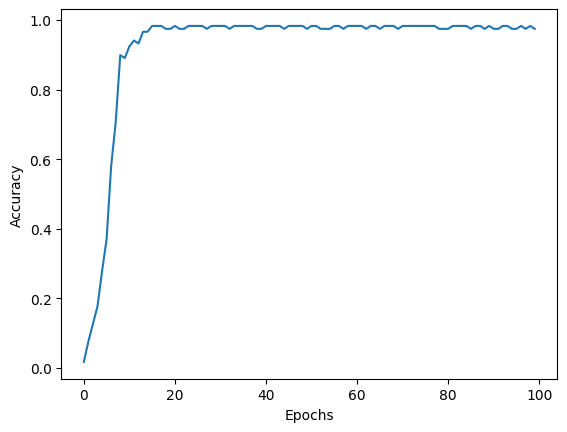

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show() #此句可有可无

In [18]:
'''test: 输入一个sequence, model就会输出下一个值, 
既而生成poetry(take a sequence and get next value, add that sequence pass that model get next value and add that sequence and so on
(输入一个序列, 得到下一个值, 将其添加到序列中, 继续传递给模型得到下一个值, 再将其添加到序列中, 以此类推))'''

'''若输入一个model之前未见过的单词序列, 它可粗略推理出下一个单词是什么
(因此为了让模型生成文本, 可输入一些单词并预测下一个值,然后将输出添加到单词字符串中进而预测下一个值, 以此类推)'''
seed_text = 'I made a poetry machine'
next_words = 20

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #注:[token_list]中, token_list本身是list(列表)有'[]', 外面再加一个'[]'是要使其成为array(数组), 因为TensorFlow 2.x中array才能放入model训练
    #maxlen = max_sequence_len-1因为测试集中的X_test(测试数据)是去掉y_test(测试label)后的前面部分
    token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
    #model.predict_classes is deprecated from tensorflow in version 2.6
    #predicted = model.predict_classes(token_list, verbose = 0) 
    #axis = 1（按列）或 -1(最后一列) (因为model.predict(token_list)的结果就为一列); 另, verbose大多数情况下默认为1
    predicted = np.argmax(model.predict(token_list, verbose = 0), axis=-1)
    output_word = ''
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += ' ' + output_word
print(seed_text)

I made a poetry machine pound party for friends and relations relations her a call call party a man give her a call call party
